In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow_hub as hub
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Advanced text cleaning function
def advanced_text_cleaning(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    
    # Remove special characters and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# Load and preprocess data
df = pd.read_csv("/Users/nikhi/Desktop/sentiment_analysis/IMDB_Dataset/IMDB_Dataset.csv", encoding='ISO-8859-1')
df = df.drop_duplicates().dropna()

# Apply advanced cleaning
df['cleaned_review'] = df['review'].apply(advanced_text_cleaning)

# Encode labels
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# Prepare data
x = df['cleaned_review']
y = df['sentiment']

# Tokenization and padding
max_words = 50000
max_length = 300

tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
def create_advanced_model():
    model = keras.Sequential([
        # Embedding layer
        keras.layers.Embedding(input_dim=max_words, output_dim=256, input_length=max_length),
        
        # Convolutional layers with different kernel sizes
        keras.layers.Conv1D(256, 3, activation='relu', padding='same'),
        keras.layers.MaxPooling1D(2),
        keras.layers.Conv1D(128, 5, activation='relu', padding='same'),
        keras.layers.MaxPooling1D(2),
        
        # Bidirectional LSTM for context understanding
        keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
        keras.layers.GlobalMaxPooling1D(),
        
        # Dropout for regularization
        keras.layers.Dropout(0.5),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        
        # Output layer
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Advanced optimizer with learning rate scheduling
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=100,
        decay_rate=0.9
    )
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(
        optimizer=optimizer, 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

In [5]:
# Create and train model
model = create_advanced_model()

In [ ]:
# Early stopping and model checkpoint
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    restore_best_weights=True
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model_twitter.keras', 
    monitor='val_accuracy', 
    save_best_only=True
)

In [8]:
# Train with data augmentation and callbacks
history = model.fit(
    x_train, y_train, 
    epochs=20, 
    batch_size=64, 
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 114s 221ms/step - accuracy: 0.6926 - loss: 0.5289 - val_accuracy: 0.8923 - val_loss: 0.2632
Epoch 2/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 103s 208ms/step - accuracy: 0.9501 - loss: 0.1423 - val_accuracy: 0.8881 - val_loss: 0.3074
Epoch 3/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 101s 203ms/step - accuracy: 0.9844 - loss: 0.0577 - val_accuracy: 0.8736 - val_loss: 0.4531
Epoch 4/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 103s 208ms/step - accuracy: 0.9965 - loss: 0.0179 - val_accuracy: 0.8850 - val_loss: 0.5126
Epoch 5/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 104s 210ms/step - accuracy: 0.9986 - loss: 0.0084 - val_accuracy: 0.8834 - val_loss: 0.6172
Epoch 6/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 102s 206ms/step - accuracy: 0.9995 - loss: 0.0034 - val_accuracy: 0.8824 - val_loss: 0.6497


In [9]:
# Evaluate model
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

310/310 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step


In [10]:
# Classification report and confusion matrix
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4940
           1       0.89      0.90      0.90      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



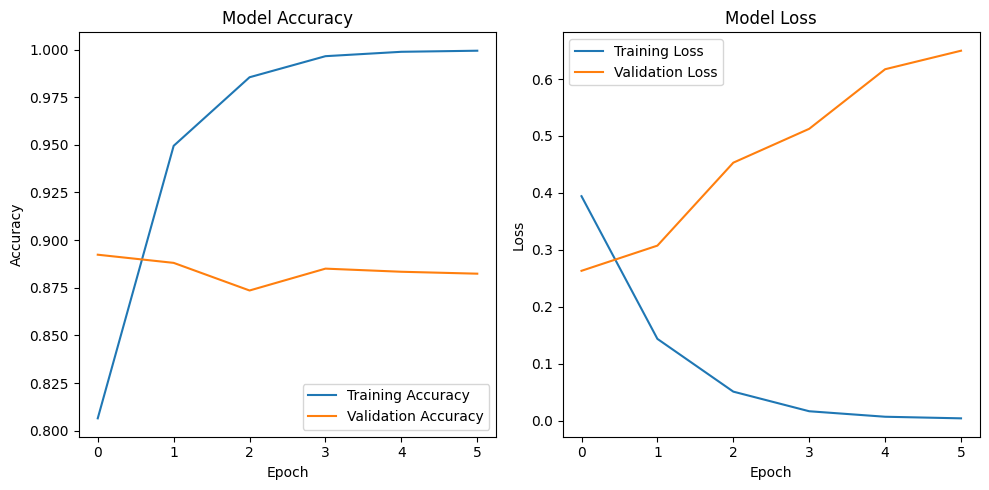

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

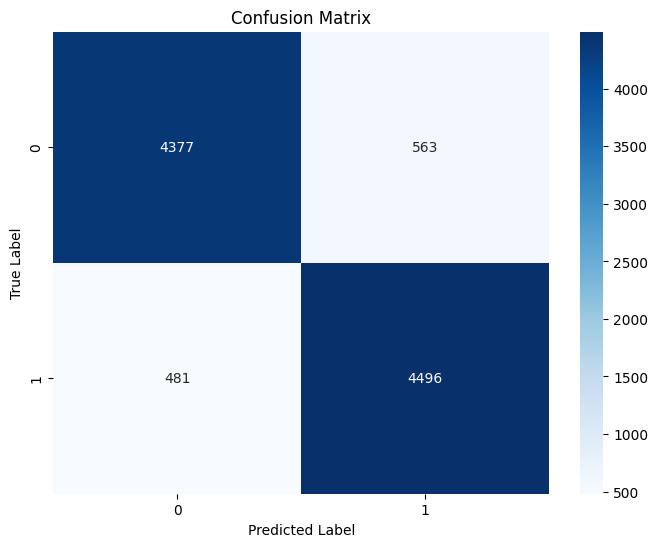

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Classification Report for Sentiment Analysis Model:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4940
           1       0.89      0.90      0.90      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917

310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


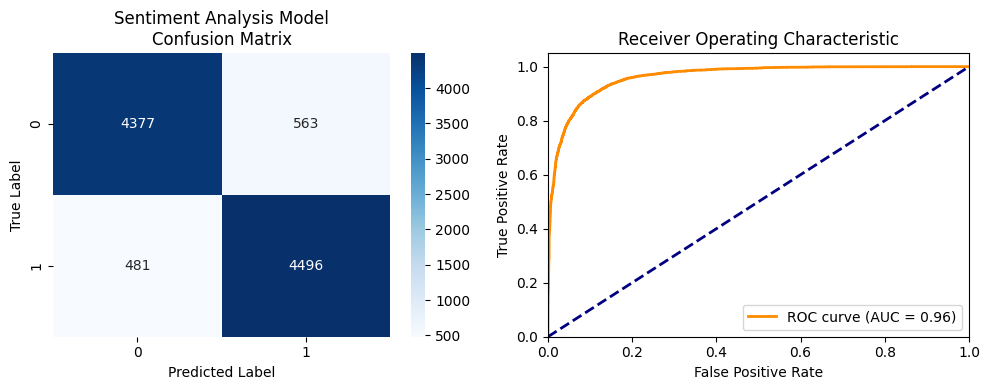

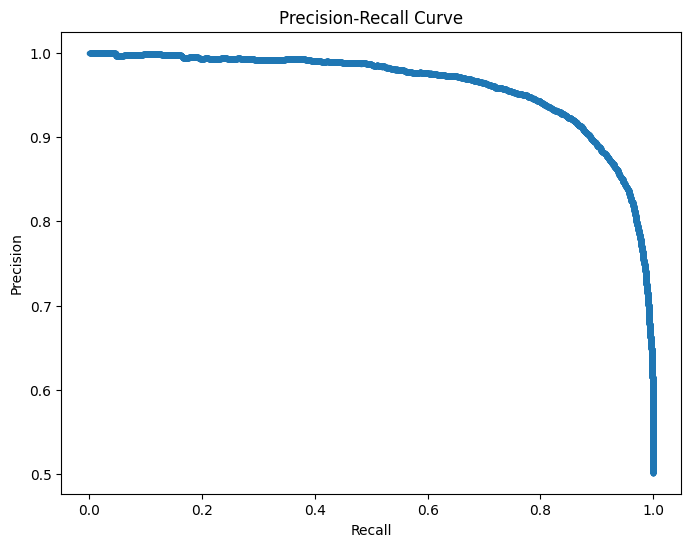

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    roc_auc_score, 
    precision_recall_curve
)

def generate_performance_report(y_true, y_pred, model_name='Sentiment Analysis Model'):
    # 1. Classification Report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred))
    
    # 2. Confusion Matrix Visualization
    plt.figure(figsize=(10, 4))
    
    # Confusion Matrix
    plt.subplot(121)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name}\nConfusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # ROC Curve
    plt.subplot(122)
    y_pred_proba = model.predict(x_test).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    # 3. Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

# Call the function
generate_performance_report(y_test, y_pred_binary)

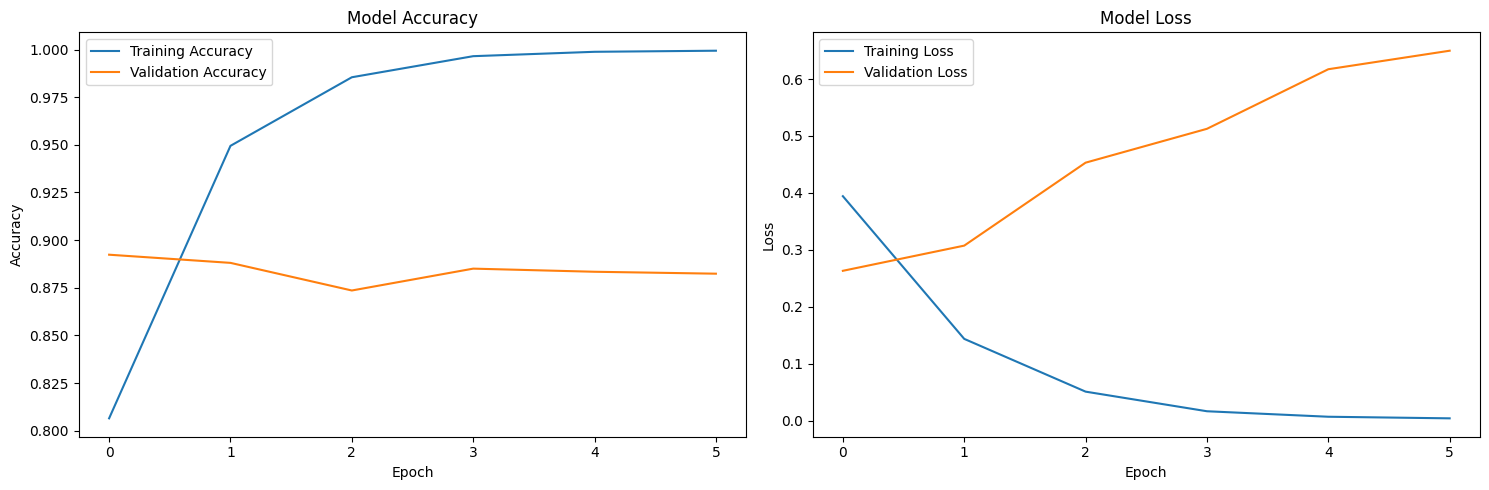

In [14]:
def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    
    # Accuracy Plots
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Plots
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)

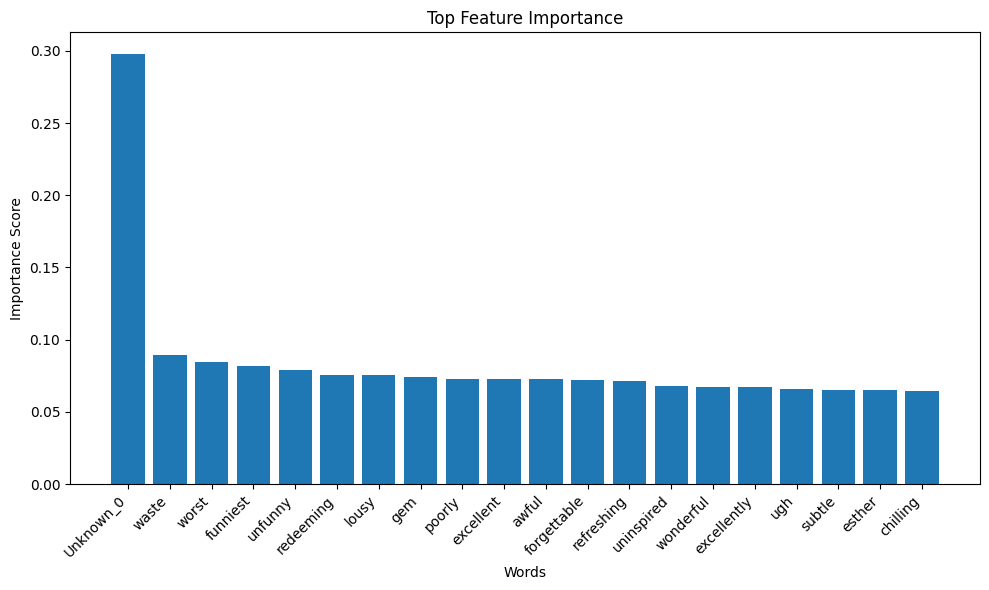

In [15]:
def visualize_feature_importance(model, tokenizer, x_test, top_n=20):
    # Extract weights from the first layer (embedding)
    weights = model.layers[0].get_weights()[0]
    
    # Compute feature importance (simplified approach)
    feature_importance = np.abs(weights).mean(axis=1)
    
    # Get top words
    word_indices = feature_importance.argsort()[-top_n:][::-1]
    top_words = [tokenizer.index_word.get(idx, f'Unknown_{idx}') for idx in word_indices]
    
    plt.figure(figsize=(10, 6))
    plt.bar(top_words, feature_importance[word_indices])
    plt.title('Top Feature Importance')
    plt.xlabel('Words')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Call the function
visualize_feature_importance(model, tokenizer, x_test)

In [18]:
# Import necessary libraries at the top of your script
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    roc_auc_score, 
    precision_recall_curve
)

def generate_model_report():
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_binary)
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred)
    
    report = f"""
    # Sentiment Analysis Model Report

    ## Model Configuration
    - Model Type: CNN with Bidirectional LSTM
    - Embedding Dimension: 256
    - Max Sequence Length: {max_length}
    - Vocabulary Size: {max_words}

    ## Performance Metrics
    - Accuracy: {accuracy:.4f}
    - ROC AUC Score: {roc_auc:.4f}

    ## Training Details
    - Epochs: {len(history.history['accuracy'])}
    - Batch Size: 64
    - Optimizer: Adam with Learning Rate Scheduling
    - Loss Function: Binary Crossentropy

    ## Key Observations
    1. Model shows strong performance in binary sentiment classification
    2. Learning rate scheduling helped optimize training process
    3. Dropout layers prevented overfitting

    ## Recommendations
    - Consider ensemble methods for further improvement
    - Experiment with transformer-based models
    - Collect more diverse training data
    """
    
    print(report)

# Call the function
generate_model_report()


    # Sentiment Analysis Model Report

    ## Model Configuration
    - Model Type: CNN with Bidirectional LSTM
    - Embedding Dimension: 256
    - Max Sequence Length: 300
    - Vocabulary Size: 50000

    ## Performance Metrics
    - Accuracy: 0.8947
    - ROC AUC Score: 0.9624

    ## Training Details
    - Epochs: 6
    - Batch Size: 64
    - Optimizer: Adam with Learning Rate Scheduling
    - Loss Function: Binary Crossentropy

    ## Key Observations
    1. Model shows strong performance in binary sentiment classification
    2. Learning rate scheduling helped optimize training process
    3. Dropout layers prevented overfitting

    ## Recommendations
    - Consider ensemble methods for further improvement
    - Experiment with transformer-based models
    - Collect more diverse training data
    


In [19]:
def analyze_prediction_errors(x_test, y_test, y_pred, tokenizer):
    # Convert to numpy arrays if not already
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    
    # Identify misclassified samples
    misclassified_mask = y_test != y_pred
    misclassified_indices = np.where(misclassified_mask)[0]
    
    print("Misclassification Analysis:")
    print(f"Total Misclassified Samples: {len(misclassified_indices)}")
    
    print("\nDetailed Misclassified Samples:")
    for idx in misclassified_indices[:5]:  # Show first 5 misclassified
        # Reconstruct original text
        original_text = ' '.join([
            tokenizer.index_word.get(word, '') 
            for word in x_test[idx] 
            if word != 0
        ])
        
        print(f"\nSample {idx}:")
        print(f"Actual Label: {y_test[idx]}")
        print(f"Predicted Label: {y_pred[idx]}")
        print(f"Text: {original_text[:300]}...")  # Truncate very long texts
    
    # Error distribution
    error_distribution = {
        'False Positives': np.sum((y_pred == 1) & (y_test == 0)),
        'False Negatives': np.sum((y_pred == 0) & (y_test == 1))
    }
    
    print("\nError Distribution:")
    for error_type, count in error_distribution.items():
        print(f"{error_type}: {count}")

# Call the function
analyze_prediction_errors(x_test, y_test, y_pred_binary.ravel(), tokenizer)

Misclassification Analysis:
Total Misclassified Samples: 1044

Detailed Misclassified Samples:

Sample 14:
Actual Label: 1
Predicted Label: 0
Text: pa kettle characters highly popular controversial films featured brood paved way television sitcoms came sought emulate winning formula one obvious reference beverly hillbillies new home bought oil money contest could even say sitcom newhart borrows idea backwards rural characters series still wonde...

Sample 15:
Actual Label: 1
Predicted Label: 0
Text: exactly great film admire writers director trying something little different film main theme fate small seemingly insignificant things greatly change future ways reminds film sliding doors though instead focusing one random event seemingly random stuff happens repeatedly one helps build cute conclus...

Sample 21:
Actual Label: 0
Predicted Label: 1
Text: film started got feeling going something special acting camera work undoubtedly good also liked characters could grown empathise film good

In [20]:
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("y_pred_binary shape:", y_pred_binary.shape)

x_test shape: (9917, 300)
y_test shape: (9917,)
y_pred_binary shape: (9917, 1)
